# Instant Recognition with Caffe

In this example we'll classify an image with the bundled CaffeNet model based on the network architecture of Krizhevsky et al. for ImageNet. We'll compare CPU and GPU operation then reach into the model to inspect features and the output.

(These feature visualizations follow the DeCAF visualizations originally by Yangqing Jia.)

First, import required modules, set plotting parameters, and run `./scripts/download_model_binary.py models/bvlc_reference_caffenet` to get the pretrained CaffeNet model if it hasn't already been fetched.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Make sure that caffe is on the python path:
caffe_root = '/opt/caffe/'  # this file is expected to be in {caffe_root}/examples
import sys
sys.path.insert(0, caffe_root + 'python')

import caffe

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

import os
if not os.path.isfile(caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'):
    print("Downloading pre-trained CaffeNet model...")
    !../scripts/download_model_binary.py ../models/bvlc_reference_caffenet

Set Caffe to CPU mode, load the net in the test phase for inference, and configure input preprocessing.

In [3]:
caffe.set_mode_cpu()
net = caffe.Net(caffe_root + 'models/bvlc_reference_caffenet/deploy.prototxt',
                caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel',
                caffe.TEST)

# input preprocessing: 'data' is the name of the input blob == net.inputs[0]
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))
transformer.set_mean('data', np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy').mean(1).mean(1)) # mean pixel
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB

Let's start with a simple classification. We'll set a batch of 50 to demonstrate batch processing, even though we'll only be classifying one image. (Note that the batch size can also be changed on-the-fly.)

In [4]:
# set net to batch size of 50
net.blobs['data'].reshape(50,3,227,227)

Feed in the image (with some preprocessing) and classify with a forward pass.

In [5]:
net.blobs['data'].data[...] = transformer.preprocess('data', caffe.io.load_image(caffe_root + 'examples/images/gunman.jpg'))
print("Starting forward pass")
out = net.forward()
print("Predicted class is #{}.".format(out['prob'].argmax()))

Starting forward pass
Predicted class is #48594.


What did the input look like?

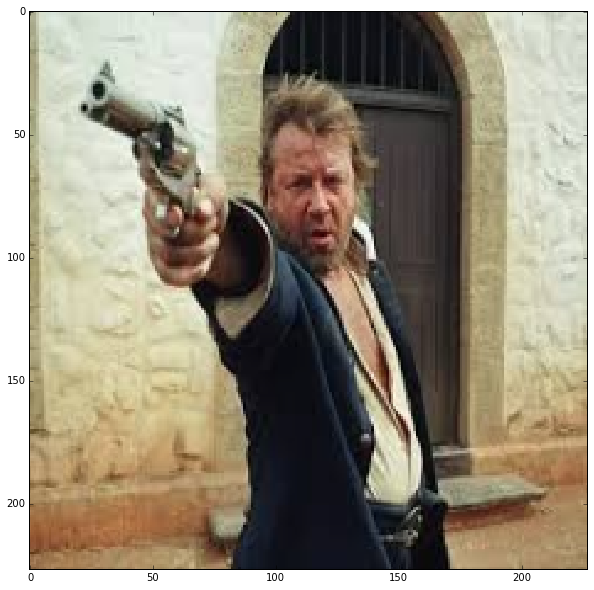

In [6]:
plt.imshow(transformer.deprocess('data', net.blobs['data'].data[0]))

Was our classification correct?

In [8]:
# load labels
imagenet_labels_filename = caffe_root + 'data/ilsvrc12/synset_words.txt'
try:
    labels = np.loadtxt(imagenet_labels_filename, str, delimiter='\t')
except:
    !../data/ilsvrc12/get_ilsvrc_aux.sh
    labels = np.loadtxt(imagenet_labels_filename, str, delimiter='\t')

# sort top k predictions from softmax output
top_k = net.blobs['prob'].data[0].flatten().argsort()[-1:-6:-1]
#probs_k = net.blobs['prob'].data[0].flatten().sort()[-1:-6:-1]
flattened = net.blobs['prob'].data[0].flatten()
flattened.sort()
print flattened[-1:-6:-1]
print labels[top_k]
#print labels[probs_k]

[ 0.14578135  0.12658338  0.08777428  0.08749839  0.06095134]
['n03495258 harp' 'n02804610 bassoon' 'n03372029 flute, transverse flute'
 'n04532106 vestment' 'n04141076 sax, saxophone']


In [ ]:
############################################################################################


In [9]:
# CPU mode
net.forward()  # call once for allocation
%timeit net.forward()

1 loops, best of 3: 7.14 s per loop


That's a while, even for a batch size of 50 images. Let's switch to GPU mode.

In [11]:
# GPU mode
caffe.set_device(0)
caffe.set_mode_gpu()
net.forward()  # call once for allocation
%timeit net.forward()

10 loops, best of 3: 90.9 ms per loop


Much better. Now let's look at the net in more detail.

First, the layer features and their shapes (1 is the batch size, corresponding to the single input image in this example).

In [8]:
[(k, v.data.shape) for k, v in net.blobs.items()]

[('data', (50, 3, 227, 227)),
 ('conv1', (50, 96, 55, 55)),
 ('pool1', (50, 96, 27, 27)),
 ('norm1', (50, 96, 27, 27)),
 ('conv2', (50, 256, 27, 27)),
 ('pool2', (50, 256, 13, 13)),
 ('norm2', (50, 256, 13, 13)),
 ('conv3', (50, 384, 13, 13)),
 ('conv4', (50, 384, 13, 13)),
 ('conv5', (50, 256, 13, 13)),
 ('pool5', (50, 256, 6, 6)),
 ('fc6', (50, 4096, 1, 1)),
 ('fc7', (50, 4096, 1, 1)),
 ('fc8', (50, 1000, 1, 1)),
 ('prob', (50, 1000, 1, 1))]

The parameters and their shapes. The parameters are `net.params['name'][0]` while biases are `net.params['name'][1]`.

In [9]:
[(k, v[0].data.shape) for k, v in net.params.items()]

[('conv1', (96, 3, 11, 11)),
 ('conv2', (256, 48, 5, 5)),
 ('conv3', (384, 256, 3, 3)),
 ('conv4', (384, 192, 3, 3)),
 ('conv5', (256, 192, 3, 3)),
 ('fc6', (1, 1, 4096, 9216)),
 ('fc7', (1, 1, 4096, 4096)),
 ('fc8', (1, 1, 1000, 4096))]

Helper functions for visualization

In [11]:
# take an array of shape (n, height, width) or (n, height, width, channels)
# and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)
def vis_square(data, padsize=1, padval=0):
    data -= data.min()
    data /= data.max()
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    print("going to plot now")
    plt.imshow(data)

The input image

The first layer filters, `conv1`

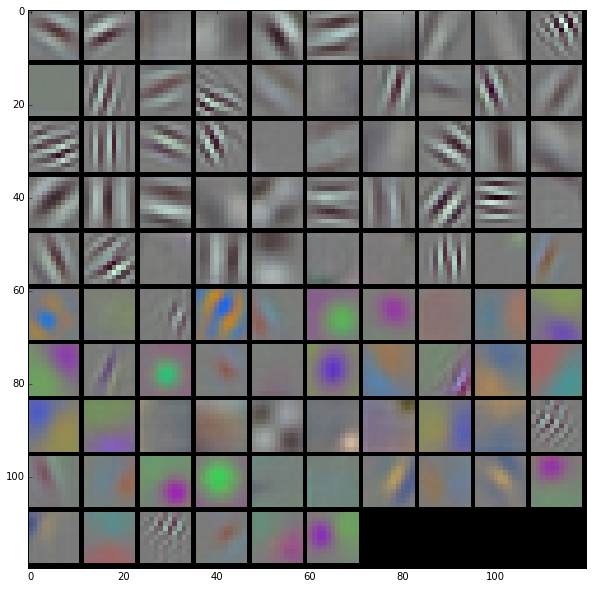

In [28]:
# the parameters are a list of [weights, biases]
filters = net.params['conv1'][0].data
vis_square(filters.transpose(0, 2, 3, 1))

The first layer output, `conv1` (rectified responses of the filters above, first 36 only)

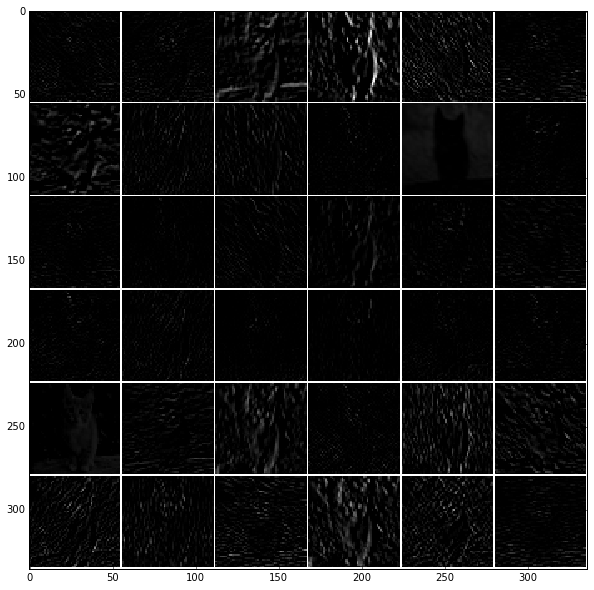

In [29]:
feat = net.blobs['conv1'].data[0, :36]
vis_square(feat, padval=1)

The second layer filters, `conv2`

There are 256 filters, each of which has dimension 5 x 5 x 48. We show only the first 48 filters, with each channel shown separately, so that each filter is a row.

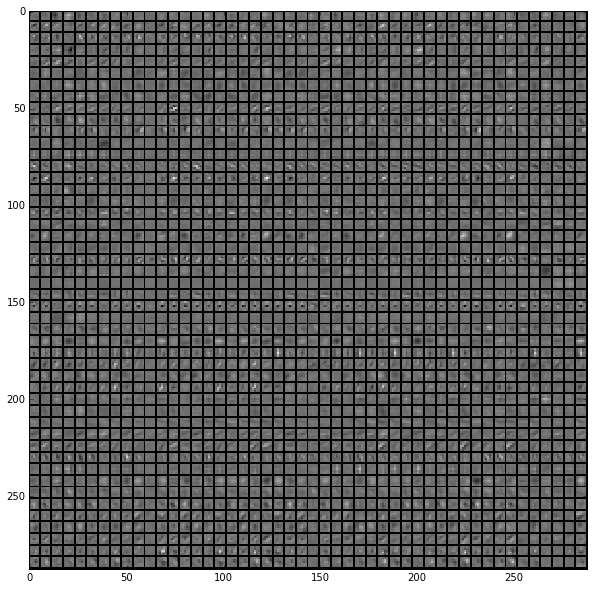

In [30]:
filters = net.params['conv2'][0].data
vis_square(filters[:48].reshape(48**2, 5, 5))

The second layer output, `conv2` (rectified, only the first 36 of 256 channels)

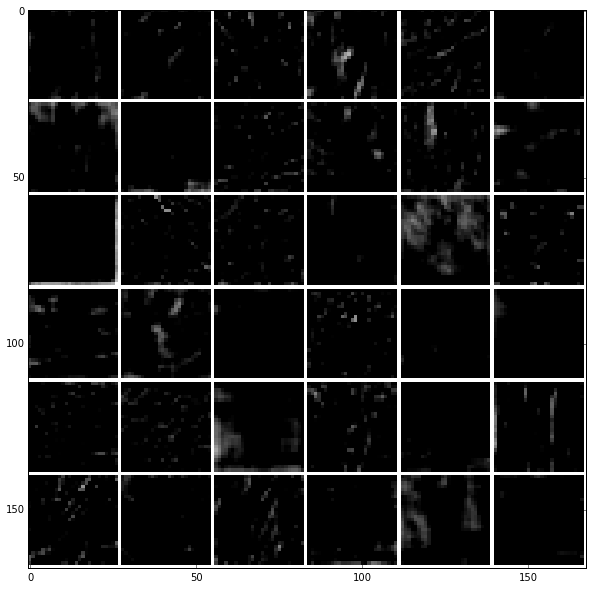

In [31]:
feat = net.blobs['conv2'].data[0, :36]
vis_square(feat, padval=1)

The third layer output, `conv3` (rectified, all 384 channels)

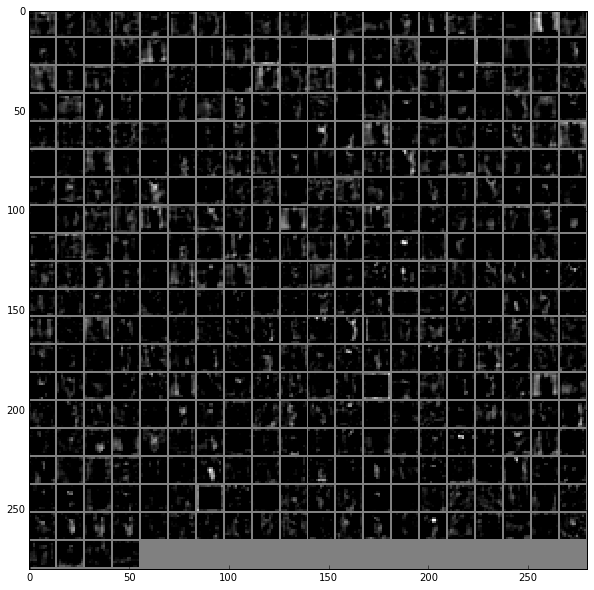

In [32]:
feat = net.blobs['conv3'].data[0]
vis_square(feat, padval=0.5)

The fourth layer output, `conv4` (rectified, all 384 channels)

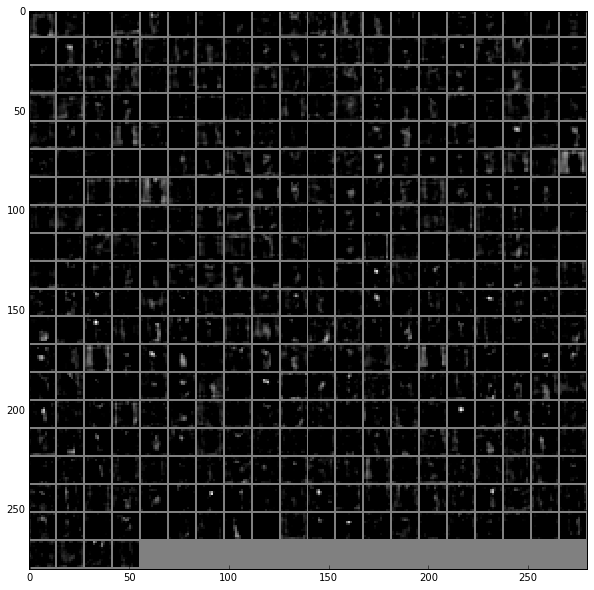

In [33]:
feat = net.blobs['conv4'].data[0]
vis_square(feat, padval=0.5)

The fifth layer output, `conv5` (rectified, all 256 channels)

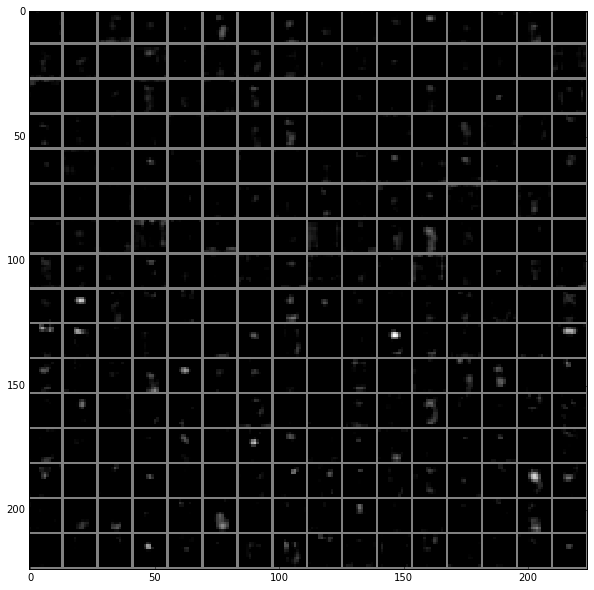

In [34]:
feat = net.blobs['conv5'].data[0]
vis_square(feat, padval=0.5)

The fifth layer after pooling, `pool5`

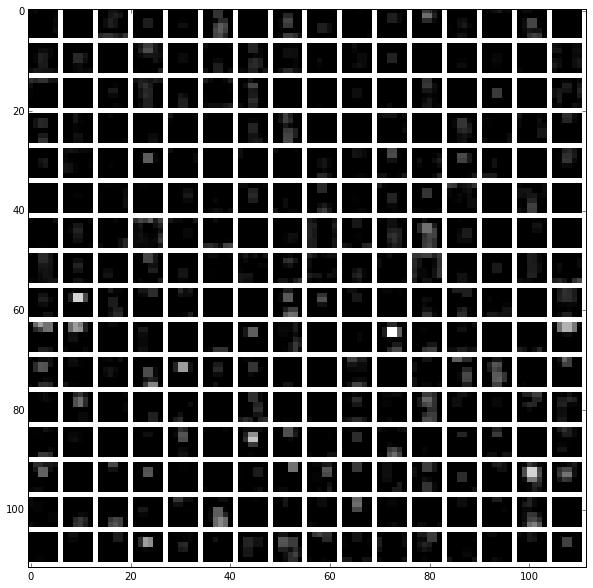

In [35]:
feat = net.blobs['pool5'].data[0]
vis_square(feat, padval=1)

The first fully connected layer, `fc6` (rectified)

We show the output values and the histogram of the positive values

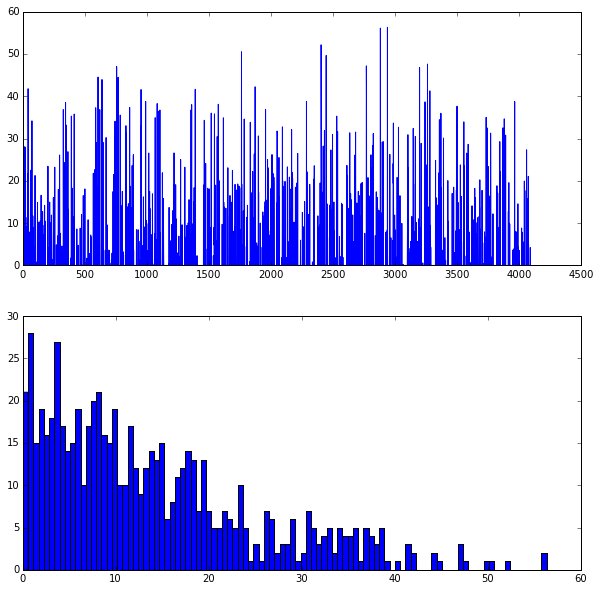

In [36]:
feat = net.blobs['fc6'].data[0]
plt.subplot(2, 1, 1)
plt.plot(feat.flat)
plt.subplot(2, 1, 2)
_ = plt.hist(feat.flat[feat.flat > 0], bins=100)

The second fully connected layer, `fc7` (rectified)

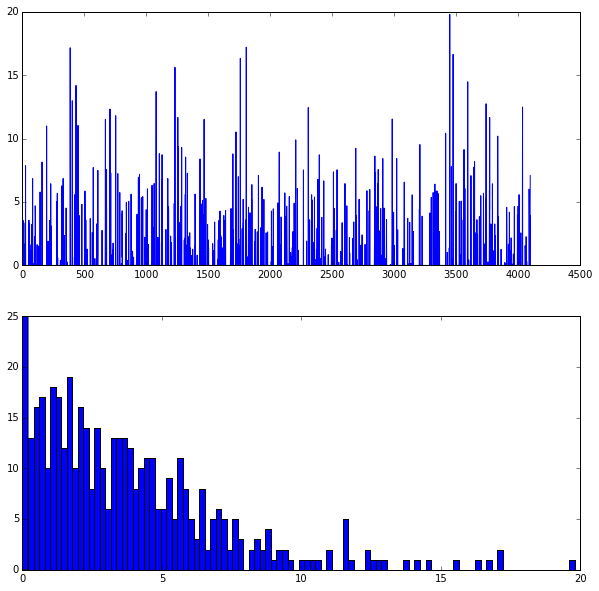

In [37]:
feat = net.blobs['fc7'].data[0]
plt.subplot(2, 1, 1)
plt.plot(feat.flat)
plt.subplot(2, 1, 2)
_ = plt.hist(feat.flat[feat.flat > 0], bins=100)

The final probability output, `prob`

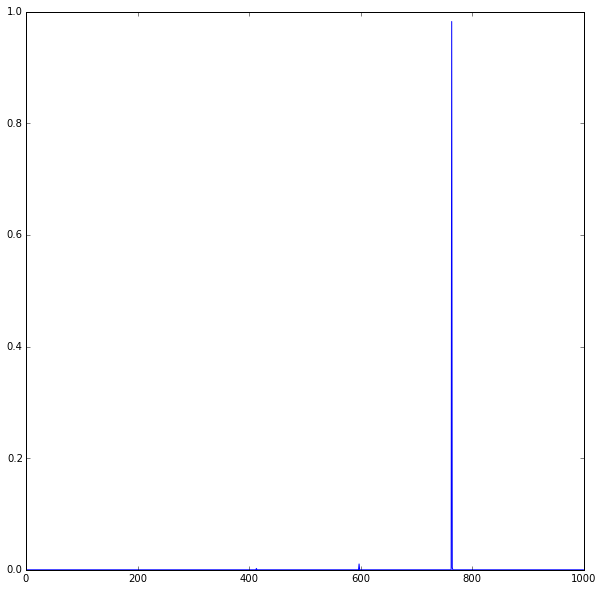

In [27]:
feat = net.blobs['prob'].data[0]
plt.plot(feat.flat)

Let's see the top 5 predicted labels.